In [51]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

def generate_Tb_spectrum(filename, script, WINDOWS=False):

    if WINDOWS:
        filename = filename[:-2] + 'bat'
        with open(filename, "w") as f:
            f.write(script)

        os.startfile(filename)

    else:
        with open(filename, "w") as f:
            f.write("#!/bin/bash\n")    # Add the shebang line
            f.write(script)
        os.chmod(filename, 0o755)       # Make the script executable

        subprocess.call(f'./{filename}')

def calc_air_mass(zenith):
    air_mass = 1/np.cos(np.radians(zenith))
    return air_mass

def calc_zenith(air_mass):
    zenith = np.degrees(np.arccos(1/air_mass))
    return zenith


In [54]:
# Generate am data only after maps are created
'''
for ZA, AM in zip(ZA_map, air_masses_map):
    for NSCALE in NSCALE_map:
        print(f"Starting am for AM={AM:.1f}; NSCALE={NSCALE:.1f}")
        freq_start = 180
        freq_end = 420
        filename="test.sh"
        script = f"""
        am MaunaKea_SON_50.amc \
            {freq_start} GHz {freq_end} GHz 1 MHz {ZA} deg 277 K {NSCALE} \
            > MaunaKea_Tb_Spectrum_{AM:.1f}_{NSCALE:.1f}.out \
            2> MaunaKea_Tb_Spectrum_{AM:.1f}_{NSCALE:.1f}.err
        """
        generate_Tb_spectrum(filename, script, WINDOWS=True)
    '''

'\nfor ZA, AM in zip(ZA_map, air_masses_map):\n    for NSCALE in NSCALE_map:\n        print(f"Starting am for AM={AM:.1f}; NSCALE={NSCALE:.1f}")\n        freq_start = 180\n        freq_end = 420\n        filename="test.sh"\n        script = f"""\n        am MaunaKea_SON_50.amc             {freq_start} GHz {freq_end} GHz 1 MHz {ZA} deg 277 K {NSCALE}             > MaunaKea_Tb_Spectrum_{AM:.1f}_{NSCALE:.1f}.out             2> MaunaKea_Tb_Spectrum_{AM:.1f}_{NSCALE:.1f}.err\n        """\n        generate_Tb_spectrum(filename, script, WINDOWS=True)\n    '

In [ ]:
NSCALE_points = 7
NSCALE_map = np.linspace(0, 3, NSCALE_points)

ZA_points = 7
air_masses_map = np.linspace(1, calc_air_mass(75), ZA_points)
# ZA_map scaling with linear air_mass
ZA_map = calc_zenith(air_masses_map)

freq_points = 240001
Tb_scalar_field = np.zeros((NSCALE_points, ZA_points, freq_points))

In [101]:
# Load data
for idx, NSCALE in enumerate(NSCALE_map):
    for jdx, ZA in enumerate(ZA_map):

        filename = f'MaunaKea_Tb_Spectrum_{ZA}_{NSCALE}'
        data = np.load(f'{filename}.out')

        freq_map = data[:,0]
        
        # Second column is Tb in K
        Tb_scalar_field[idx,jdx] = data[:,2]

# Pass freq in points
interp_func = RegularGridInterpolator(points=(NSCALE_map[::2], ZA_map[::2], freq_map), 
                                   values=Tb_scalar_field[::2,::2], 
                                   method="linear")

x,y,z = np.meshgrid(NSCALE_map[1::2], ZA_map[1::2], freq_map)
a,b,c = np.meshgrid(NSCALE_map[::2], ZA_map[::2], freq_map)

# Must be fed one-dim
eval_grid = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)
comparison_grid = (eval_grid - Tb_scalar_field[1::2,1::2]) / Tb_scalar_field[1::2,1::2] * 100

verify_grid = interp_func((a.flatten(),b.flatten(),c.flatten())).reshape(a.shape)
comparison_verify = (Tb_scalar_field[::2,::2] - verify_grid)

Text(0, 0.5, 'Deviation [%]')

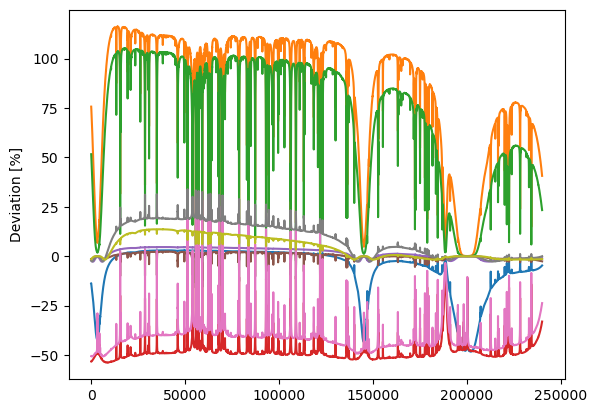

In [104]:
for idx in range(0, 3):
    for jdx in range(0, 3):
        plt.plot(comparison_grid[idx][jdx])

#names = ['NSCALE', 'Elevation', 'Frequency']
#plt.legend(names, loc=(1.01, 0.82))
plt.ylabel("Deviation [%]")

Text(0, 0.5, 'Deviation [%]')

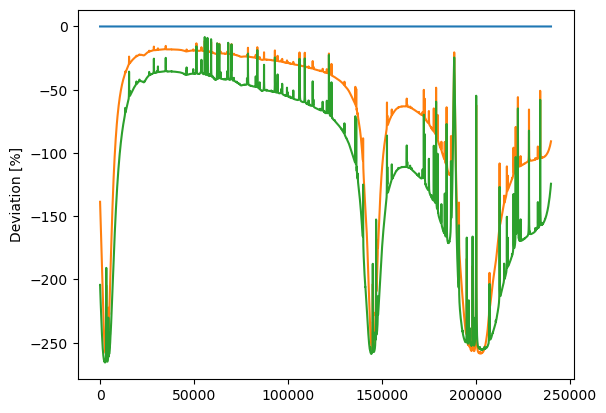

In [108]:
for idx in range(0, 3):
    plt.plot(comparison_verify[0][idx])

#names = ['NSCALE', 'Elevation', 'Frequency']
#plt.legend(names, loc=(1.01, 0.82))
plt.ylabel("Deviation [%]")

In [100]:
comparison_grid.shape

(3, 3, 240001)

In [111]:
from scipy.interpolate import CubicHermiteSpline

# Pass freq in points
interp_func = CubicHermiteSpline(x = (NSCALE_map[::2], ZA_map[::2], freq_map),
                                 y = Tb_scalar_field[::2,::2])

x,y,z = np.meshgrid(NSCALE_map[1::2], ZA_map[1::2], freq_map)
a,b,c = np.meshgrid(NSCALE_map[::2], ZA_map[::2], freq_map)

# Must be fed one-dim
eval_grid = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)
comparison_grid = (eval_grid - Tb_scalar_field[1::2,1::2]) / Tb_scalar_field[1::2,1::2] * 100

verify_grid = interp_func((a.flatten(),b.flatten(),c.flatten())).reshape(a.shape)
comparison_verify = (Tb_scalar_field[::2,::2] - verify_grid)

TypeError: CubicHermiteSpline.__init__() missing 1 required positional argument: 'dydx'

In [181]:
# Plotting labels
title = 'MaunaKea (Sept, Oct, Nov)'
elevation = '12.5'
nscale = '0.5'
T_unit = 'K'
PWV_unit = 'mm'
freq_unit = 'GHz'
theta_unit = 'deg'
tau_unit = 'np'

Text(0.5, 1.0, 'MaunaKea (Sept, Oct, Nov) [PWV=1.0]')

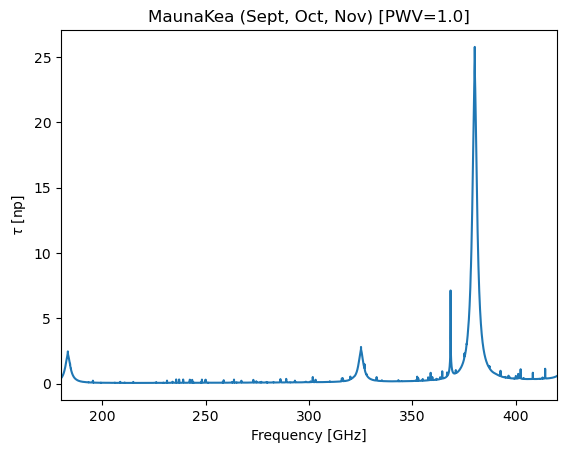

In [149]:
plt.plot(data[:,0], data[:,1])

plt.xlim(min(data[:,0]), max(data[:,0]))
plt.ylabel(r'$\tau$ ' + f'[{tau_unit}]')
plt.xlabel(f'Frequency [{freq_unit}]')
plt.title(f'{title} [PWV={float(nscale)*2}]')

Text(0.5, 1.0, 'MaunaKea (Sept, Oct, Nov) [PWV=1.0]')

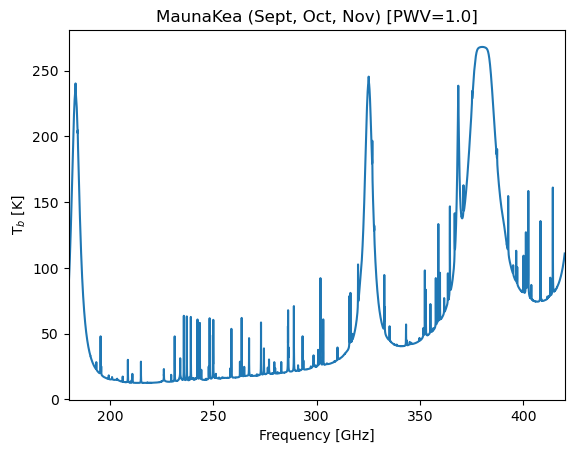

In [150]:
plt.plot(data[:,0], data[:,2])

plt.xlim(min(data[:,0]), max(data[:,0]))
plt.ylabel(r'T$_b$ ' + f'[{T_unit}]')
plt.xlabel(f'Frequency [{freq_unit}]')
plt.title(f'{title} [PWV={float(nscale)*2}]')

Text(0.5, 1.0, 'MaunaKea (Sept, Oct, Nov) [PWV=1.0]')

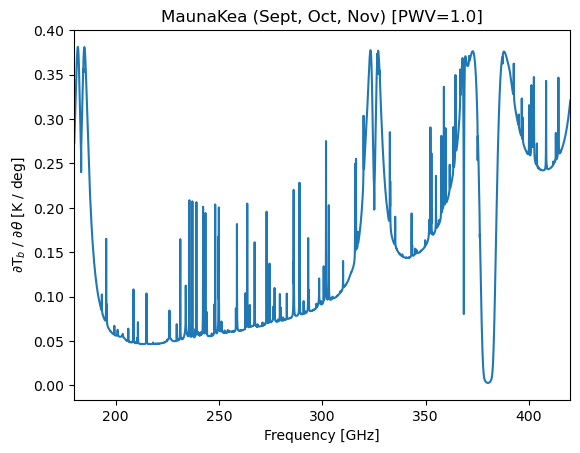

In [151]:
plt.plot(data[:,0], data[:,3])

plt.xlim(min(data[:,0]), max(data[:,0]))
plt.ylabel(r'$\partial$T$_b$ / $\partial$$\theta$ ' + f'[{T_unit} / {theta_unit}]')
plt.xlabel(f'Frequency [{freq_unit}]')
plt.title(f'{title} [PWV={float(nscale)*2}]')

Text(0.5, 1.0, 'MaunaKea (Sept, Oct, Nov) [PWV=1.0]')

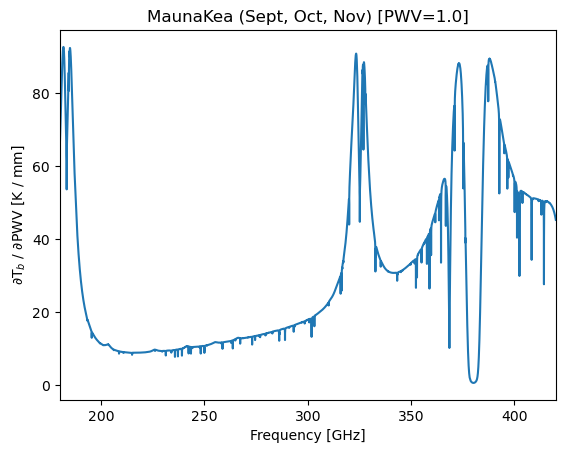

In [152]:
conversation_factor = 2109.86 * 10**-3
plt.plot(data[:,0], (data[:,4] / conversation_factor))

plt.xlim(min(data[:,0]), max(data[:,0]))
plt.ylabel(r'$\partial$T$_b$ / $\partial$PWV ' + f'[{T_unit} / {PWV_unit}]')
plt.xlabel(f'Frequency [{freq_unit}]')
plt.title(f'{title} [PWV={float(nscale)*2}]')